## Lecture-13 : Uncertainity-Quantification

## Table of Contents
#### 1. [Bayseisan Neural Network for Function Approximation](#Bayseisan-Neural-Network-for-Function-Approximation)


### Bayseisan Neural Network for Function Approximation

In [77]:
!pip install tensorflow-probability

In [3]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io as io

In [4]:
class DNN:
    def __init__(self, layers):
        self.layers = layers

    def fnn(self, X, w0, w1, b0, b1, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        A = tf.tanh(tf.add(tf.matmul(A, w0), b0))
        Y = tf.add(tf.matmul(A, w1), b1)
        return Y

    def fnn_output(self, X, w0, w1, b0, b1, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        A = tf.tanh(tf.add(tf.einsum('ij, bjk->bik', A, w0), b0))
        Y = tf.add(tf.einsum('bij, bjk->bik', A, w1), b1)
        return Y


np.random.seed(1234)
tf.random.set_seed(1234)
tfd = tfp.distributions

num_samples = int(1e3)
num_burnin = int(2e3)
noise_scale = 0.01

layers = [2] + [50] + [1]
sigma = np.float32(1.4)
H_scale = np.float32(1.0/np.sqrt(layers[1]))

def lf_training_data():
    data = io.loadmat('lf_pred')
    y_lf_train = data['y_lf_hf']
    y_lf_test = data['y_lf_pred']
    return y_lf_train, y_lf_test

def hf_func(x):
    y = (x - np.sqrt(2.0))*np.sin(8*np.pi*x)**2
    y = y.astype(np.float32)
    return y

def hf_training_data(x):
    y_mean = hf_func(x)
    noise = noise_scale*np.random.normal(0, 1, size=x.shape)
    y = y_mean + noise
    y = y.astype(np.float32)
    return y

def make_prior():
    prior_w_0 = tfd.Normal(loc=0., scale=sigma)
    prior_w_1 = tfd.Normal(loc=0., scale=sigma*H_scale)
    prior_b_0 = tfd.Normal(loc=0., scale=1.)
    prior_b_1 = tfd.Normal(loc=0., scale=1.)
    return prior_w_0, prior_w_1, prior_b_0, prior_b_1 

def make_likelihood(X, model, w0, w1, b0, b1, Xmin, Xmax):
    #surrogate model
    y_pred = model.fnn(X, w0, w1, b0, b1, Xmin, Xmax)
    return tfd.Normal(loc=y_pred, scale = noise_scale*tf.ones_like(y_pred))


def main():
    data = io.loadmat('data')
    x = data['x'] 
    x = np.reshape(x, (-1, 1))
    x = x.astype(np.float32)
    y_lf_train, y_lf_test = lf_training_data()
    y_hf = hf_training_data(x)
    x0 = x.min(0)
    x1 = x.max(0)
    y_lf_0 = y_lf_test.min(0)
    y_lf_1 = y_lf_test.max(0)
    Xmin = np.hstack((x0, y_lf_0))
    Xmax = np.hstack((x1, y_lf_1))
    Xmin = np.reshape(Xmin, (-1, 2))
    Xmax = np.reshape(Xmax, (-1, 2))
    X = np.hstack((x, y_lf_train))
    train_dict = {'x_hf': x, 'y_hf_train': y_hf, 'y_lf_train':y_lf_train}
    io.savemat('y_hf_train.mat', train_dict)

    model = DNN(layers)

    w_0_init = tf.zeros([layers[0], layers[1]], dtype=tf.float32)
    w_1_init = tf.zeros([layers[1], layers[2]], dtype=tf.float32)
    b_0_init = tf.zeros([1, layers[1]], dtype=tf.float32)
    b_1_init = tf.zeros([1, layers[2]], dtype=tf.float32)

    @tf.function
    def mcmc_sample():
        prior_w_0, prior_w_1, prior_b_0, prior_b_1 = make_prior()
        def posterior(w_0, w_1, b_0, b_1):
            likelihood = make_likelihood(X, model, w_0, w_1, b_0, b_1, Xmin, Xmax)
            return (tf.reduce_sum(prior_w_0.log_prob(w_0)) + \
                    tf.reduce_sum(prior_w_1.log_prob(w_1)) + \
                    tf.reduce_sum(prior_b_0.log_prob(b_0)) + \
                    tf.reduce_sum(prior_b_1.log_prob(b_1)) + \
                    tf.reduce_sum(likelihood.log_prob(y_hf)))

        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
                       tfp.mcmc.HamiltonianMonteCarlo(
                       target_log_prob_fn=posterior,
                       num_leapfrog_steps=20,
                       step_size=0.1),
                       num_adaptation_steps = int(num_burnin*0.8))

        def run_chain():
            samples, is_accepted = tfp.mcmc.sample_chain(
                                   num_results = num_samples,
                                   num_burnin_steps = num_burnin,
                                   current_state = [w_0_init, w_1_init, b_0_init, b_1_init],
                                   kernel = adaptive_hmc,
                                   trace_fn = lambda _, previous_kernel_results: \
                previous_kernel_results.inner_results.is_accepted)
            return samples, is_accepted

        samples_, is_accepted_ = run_chain()
        return samples_, is_accepted_

    start_time = time.perf_counter()
    samples, is_accepted = mcmc_sample()
    w0_samples, w1_samples, b0_samples, b1_samples = samples
    stop_time = time.perf_counter()
    print('Duration time is %.3f seconds'%(stop_time - start_time))

    w0_ = tf.convert_to_tensor(w0_samples, dtype=tf.float32)
    w1_ = tf.convert_to_tensor(w1_samples, dtype=tf.float32)
    b0_ = tf.convert_to_tensor(b0_samples, dtype=tf.float32)
    b1_ = tf.convert_to_tensor(b1_samples, dtype=tf.float32)
    is_accepted_test = is_accepted

    num_test = 1000
    x_test = np.linspace(0, 1, num_test).reshape((-1, 1))
    x_test = x_test.astype(np.float32)
    y_ref = hf_func(x_test) 
    X_test = np.hstack((x_test, y_lf_test))
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_pred_ = model.fnn_output(X_test, w0_, w1_, b0_, b1_, Xmin, Xmax)
    y_pred_ = y_pred_.numpy()
    Y_test = np.squeeze(y_pred_)

    hf_dict = {'x_pred': x_test, 'y_hf_samples': Y_test, 'y_hf_true': y_ref}
    io.savemat('y_hf_pred.mat', hf_dict)
    
    acceptance_rate = tf.reduce_mean(tf.cast(is_accepted_test, tf.float32))
    print('Acceptance rate: %.3f'%(acceptance_rate.numpy()))

if __name__ == '__main__':
    main()

Duration time is 9.203 seconds
Acceptance rate: 0.242


In [5]:
#Load Predicted Output
d = io.loadmat('y_hf_pred.mat')
dt = io.loadmat('y_hf_train.mat')
x_hf_smaple = dt['x_hf']
yt_sample = dt['y_hf_train']
yt_lf = dt['y_lf_train']
y_hf_smaple = d['y_hf_samples']
y_hf_true = d['y_hf_true']
y_hf_mean = np.mean(y_hf_smaple, axis=0)
y_hf_std = np.std(y_hf_smaple, axis=0)

y_hf_mean = y_hf_mean.reshape((-1,1))
y_hf_std = y_hf_std.reshape((-1,1))
x_pred = d['x_pred'].reshape((-1,1))
lower_bound = y_hf_mean - 2*y_hf_std
upper_bound = y_hf_mean + 2*y_hf_std



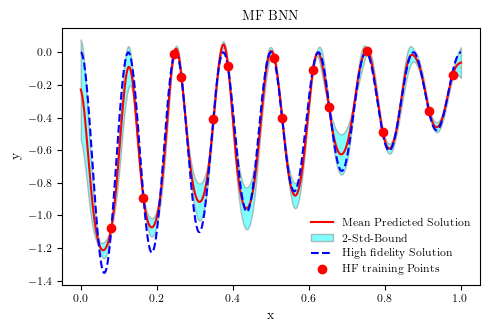

In [21]:
import sys
sys.path.insert(0, 'Utilities/')
import os


from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.plot(x_pred, y_hf_mean, '-r', label="Mean Predicted Solution")
ax.fill_between(x_pred[:,0], lower_bound[:,0], upper_bound[:,0], alpha=0.5, edgecolor='gray', facecolor='cyan',\
                 label="2-Std-Bound")
ax.plot(d['x_pred'].reshape((-1,1)), d['y_hf_true'].reshape((-1,1))[0:1000], '--b', label="High fidelity Solution")
ax.plot(x_hf_smaple, yt_sample, "or", label="HF training Points")
ax.set_xlabel('x')
ax.set_ylabel("y")
ax.legend(frameon=False, loc = 'best')
ax.set_title("MF BNN", fontsize = 10)
plt.savefig("BNN", dpi=300)
plt.show()



In [22]:
!pwd

/Users/raj/Dropbox (Brown)/NVIDIA-COURSE/KTH_COURSE_2023/DAY_7/Jupyter_Notebook/MF_BNN
